# Student Performance - Revisited

In [19]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'
## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor



## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)



The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [2]:
## Load in the student performance data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"
df = pd.read_excel(url,sheet_name='student-por')
df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


## Predicting Actual G3 Grades

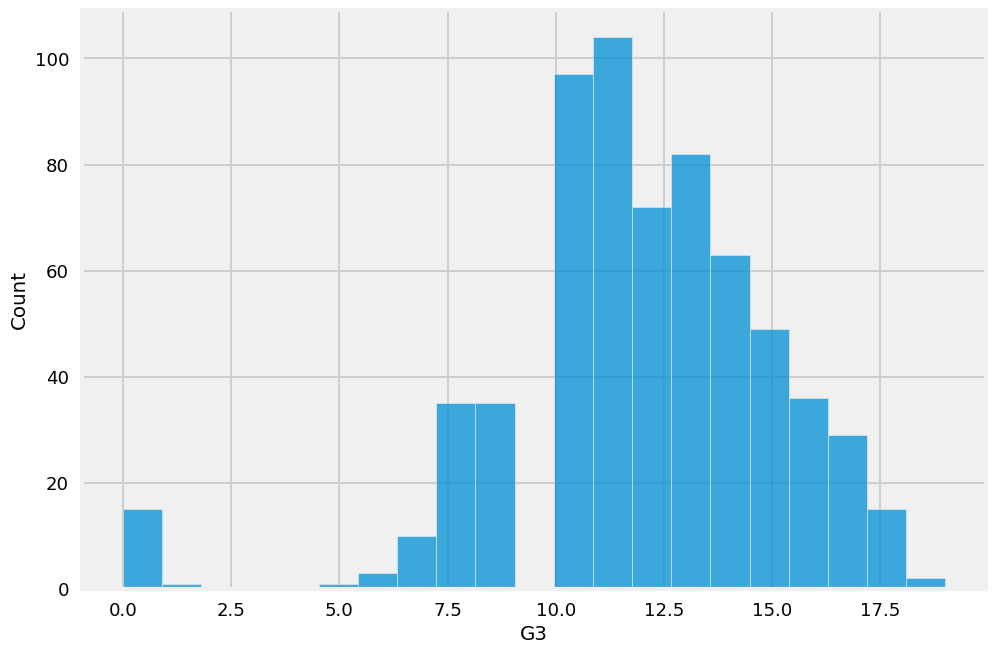

In [3]:
sns.histplot(df['G3']);



## Preprocessing

In [4]:
# ### Train Test Split
## Make x and y variables
drop_feats = ['G1','G2']
y = df['G3'].copy()
X = df.drop(columns=['G3',*drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)

# ### Preprocessing + ColumnTransformer
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')


## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'), OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)



,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


## Modeling - RandomForestRegressor

In [6]:
## fit random forest

rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
print(f"Training R^2: {rf_reg.score(X_train_df,y_train):.3f}")
print(f"Test R^2: {rf_reg.score(X_test_df, y_test):.3f}")



Training R^2: 0.892
Test R^2: 0.356


## Using SHAP with Regression Models

In [7]:
import shap
shap.initjs()



In [8]:
X_shap = shap.sample(X_train_df, nsamples=200, random_state=321)
X_shap



,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
473,16.0,2.0,1.0,2.0,1.0,0.0,2.0,4.0,3.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
340,17.0,3.0,3.0,1.0,1.0,0.0,4.0,4.0,3.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
452,16.0,2.0,2.0,3.0,2.0,0.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
555,16.0,1.0,2.0,1.0,3.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
70,16.0,3.0,1.0,2.0,4.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,18.0,1.0,4.0,1.0,2.0,0.0,3.0,4.0,4.0,1.0,2.0,5.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
443,15.0,4.0,1.0,1.0,2.0,0.0,5.0,3.0,4.0,1.0,2.0,2.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
120,15.0,1.0,2.0,1.0,2.0,0.0,3.0,2.0,3.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
294,18.0,2.0,2.0,1.0,2.0,0.0,3.0,2.0,3.0,1.0,1.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [9]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap



473    10
340    15
452    11
555    13
70     11
       ..
353    11
443     8
120    14
294    13
340    15
Name: G3, Length: 200, dtype: int64

### Explaining Our RandomForestRegressor with SHAP

In [10]:
explainer = shap.Explainer(rf_reg)
explainer



In [11]:
# calculate the shap_values by running the explainer as a function with X_shap and y_shap as the arguments.

shap_values = explainer(X_shap,y_shap)
shap_values.shape



(200, 43)

In [12]:
X_shap.shape



(200, 43)

### Summary Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


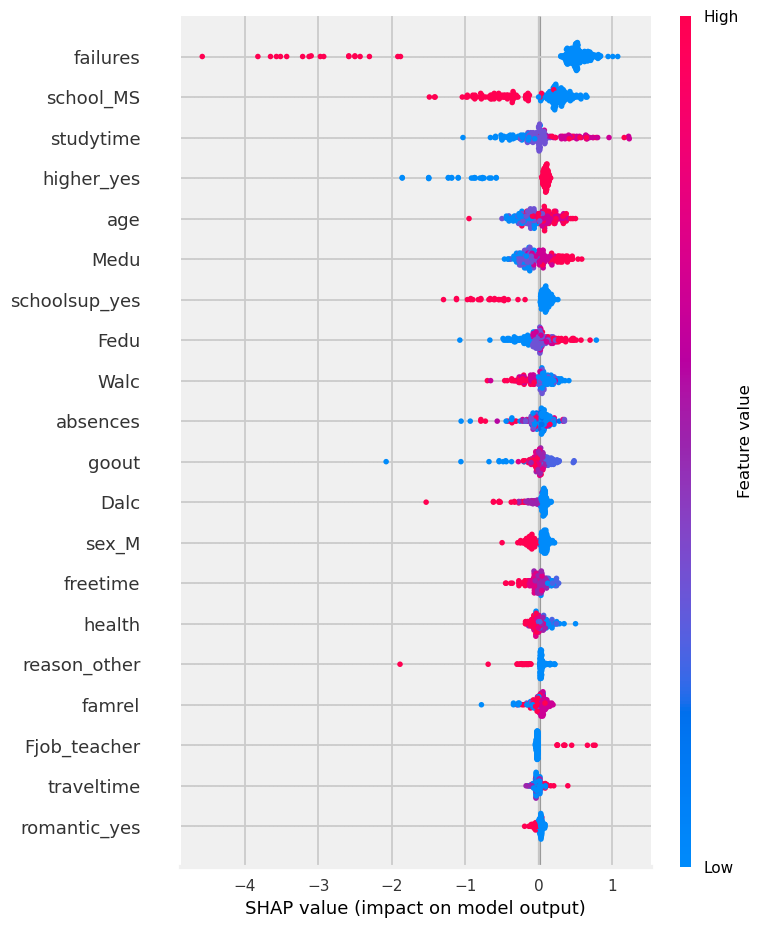

In [13]:
shap.summary_plot(shap_values,X_shap)



### Global Force Plot

In [14]:
## Global Force Plot
shap.force_plot(explainer.expected_value, shap_values.values, features=X_shap)



## LinearRegression

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
print(f"Training R^2: {lin_reg.score(X_train_df,y_train):.3f}")
print(f"Test R^2: {lin_reg.score(X_test_df, y_test):.3f}")



Training R^2: 0.350
Test R^2: 0.349


In [17]:
linreg_explainer = shap.Explainer(lin_reg, X_shap)
linreg_explainer



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


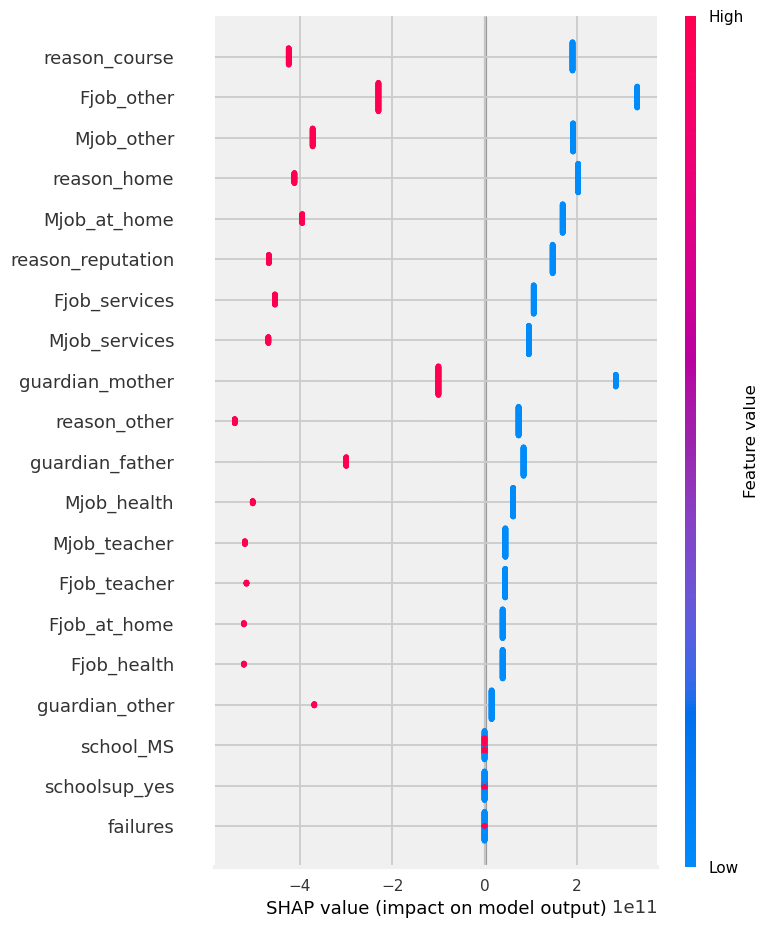

In [18]:
linreg_shap_values = linreg_explainer(X_shap)
shap.summary_plot(linreg_shap_values,X_shap)



## KNN

In [20]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_df, y_train)
print(f"Training R^2: {knn_reg.score(X_train_df,y_train):.3f}")
print(f"Test R^2: {knn_reg.score(X_test_df, y_test):.3f}")



Training R^2: 0.396
Test R^2: 0.061


In [21]:
explainer_knn = shap.Explainer(knn_reg.predict, X_shap)
explainer_knn



Permutation explainer: 201it [01:41,  1.81it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


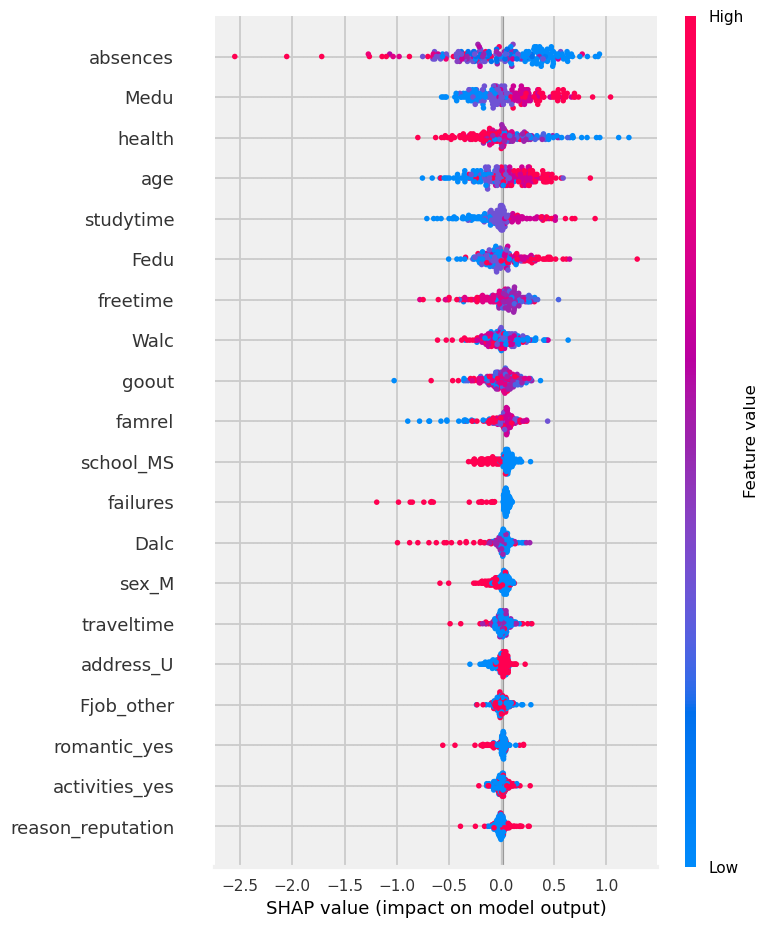

In [22]:
shap_vals_knn = explainer_knn(X_shap)
shap.summary_plot(shap_vals_knn,X_shap)

